In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as skmts
import sklearn.preprocessing as skpre
import scipy.stats as scistat
import glob
import pickle
import statsmodels.stats.multitest as multi
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
def get_perTriplet_performance(data_path):
    """return overall performance across folds
    :param data_path: path to model_prediction.txt
    """
    # collect files
    df_list = []
    for f in glob.glob(data_path+'*.model_prediction.txt'):
        df = pd.read_csv(f, header=0, sep="\t")
        df_list.append(df)
    df = pd.concat(df_list, axis=0)
    
    # get triplet from icombo
    df[['did_row', 'did_col', 'cid', 'conc_r', 'conc_c']]= df['icombo'].str.split('=', expand=True)
    df['triplet'] = df['did_row'] + '_' + df['did_col'] + '_' + df['cid']
   
    
    # collect qualified triplets: have positives and negatives  
    g = df.groupby(by=['triplet'])['synergy_label'].agg('mean').to_frame('#label')
    all_pos = g[g['#label']==1].index.tolist()
    all_neg = g[g['#label']==0].index.tolist()
    triplet_list = sorted(set(g.index) - set(all_pos+all_neg))
    
    # get per-triplet performance
    record_list = [] # (N, AUC, AUPRC)
    grps = df.groupby(['triplet'])
    for triplet in triplet_list:
        sample = grps.get_group(triplet)
        auc = skmts.roc_auc_score(sample['synergy_label'], sample['predicted_synergy'])
        auprc = skmts.average_precision_score(sample['synergy_label'], sample['predicted_synergy'])
        record_list.append( (len(sample), auc, auprc) )
    df = pd.DataFrame.from_records(record_list, index=triplet_list, columns=['N', 'AUC', 'AUPRC'])
    df = df.sort_values(by=['N', 'AUPRC', 'AUC'], ascending=False)
    print(f'Top 10 triplet:\n{df.head(10)}')
    
    # calculate mean , standard deviation
    print(f'per-triplet performance')
    print(pd.concat([df.mean(axis=0).to_frame(name='mean'), df.std(axis=0).to_frame(name='standard deviation')], axis=1))
    
    return df

In [3]:
cv_path = '../data/cv_data/ONEIL/classification/random_split/test/'
input_path = '../data/input_data/EXP/c3/transform_ssGSEA/kmer9/'
output_path = '../classification/random_split/EXP/c3/DRUG_CELL_DOSE/transform_ssGSEA/kmer9/'
kfold = 10

In [4]:
cv_dict = {} # cv_str: fname
pred_dict = {} # cv_str: fname
emb_dict = {}
for k in range(0, kfold):
    cv_str = 'cv_' + str(k)
    for f in glob.glob(cv_path+'*.data.pkl'):
        if cv_str in f:
            cv_dict[cv_str] = f
            
    for f in glob.glob(output_path+'*.model_prediction.txt'):
        if cv_str in f:
            pred_dict[cv_str] = f
            
    for f in glob.glob(output_path+'*.subgraph_embeddings_attentionweights.pkl'):
        if cv_str in f:
            emb_dict[cv_str] = f
            
print(f'kfold={kfold}: cv files={len(cv_dict)} | embedding files={len(emb_dict)} | prediction files={len(pred_dict)}')

kfold=10: cv files=10 | embedding files=10 | prediction files=10


In [5]:
dose_df = pd.read_pickle(input_path+'dose_subgraph.pkl').T # icombo by geneset
chem_df = pd.read_pickle(input_path+'chemical_subgraph.pkl').T # icombo by kmer, geneset

cv_list = []
pred_list = []
cell_attn_list = []
target_attn_list = []
kmer_attn_list = []
for k in range(0, kfold):
    cv_str = 'cv_' + str(k)
    
    # load data
    cv_df = pd.read_pickle(cv_dict[cv_str])
    pred_df = pd.read_csv(pred_dict[cv_str], header=0, sep="\t")
    with open(emb_dict[cv_str], 'rb') as fin:
        subg_dict = pickle.load(fin)
        
        # dose
        #dose_emb = emb_dict['dose'][0]
        dose_attn = pd.DataFrame(subg_dict['dose'][1], 
                                 index=cv_df['icombo'], columns=dose_df.columns)
    
        # chemical
        #chemical_emb = emb_dict['chemical'][0]
        chemical_attn = pd.DataFrame(subg_dict['chemical'][1],
                                     index=cv_df['icombo'], columns=chem_df.columns)
        
        g_list = [col for col in chemical_attn.columns if 'GENES' in col]
        k_list = sorted( set(chem_df.columns)-set(g_list) )
        target_attn = chemical_attn[g_list]
        kmer_attn = chemical_attn[k_list]
        
    # append to list
    cv_list.append(cv_df)
    pred_list.append(pred_df)
    cell_attn_list.append(dose_attn)
    kmer_attn_list.append(kmer_attn)
    target_attn_list.append(target_attn)

# merge all
cv_df = pd.concat(cv_list, axis=0)
pred_df = pd.concat(pred_list, axis=0)
cell_df = pd.concat(cell_attn_list, axis=0)
target_df = pd.concat(target_attn_list, axis=0)
kmer_df = pd.concat(kmer_attn_list, axis=0)
print(f'cv_df={cv_df.shape}: attention weight: cell={cell_df.shape} | target={target_df.shape} | kmer={kmer_df.shape}')

cv_df=(60770, 12): attention weight: cell=(60770, 227) | target=(60770, 227) | kmer=(60770, 9391)


In [6]:
weighted_subg_dict = {'cell':None, 'target':None, 'kmer':None}

scaler = skpre.MinMaxScaler().set_output(transform="pandas").fit(dose_df)
dose_df = scaler.transform(dose_df)
scaler = skpre.MinMaxScaler().set_output(transform="pandas").fit(chem_df)
chem_df = scaler.transform(chem_df)


icombo = sorted(set(cell_df.index) & set(dose_df.index))
dose_subg = dose_df.loc[icombo]
chem_subg = chem_df.loc[icombo]

g_list = [col for col in chem_subg.columns if 'GENES' in col]
k_list = sorted( set(chem_subg.columns)-set(g_list) )
target_subg = chem_subg[g_list]
kmer_subg = chem_subg[k_list]


weighted_cell_df = (dose_subg * cell_df).replace({-0:0})
weighted_target_df = (target_subg * target_df).replace({-0:0})
weighted_kmer_df = (kmer_subg * kmer_df).replace({-0:0})

weighted_cell_df = weighted_cell_df.loc[:, (weighted_cell_df!=0).any(axis=0)]
weighted_target_df = weighted_target_df.loc[:, (weighted_target_df!=0).any(axis=0)]
weighted_kmer_df = weighted_kmer_df.loc[:, (weighted_kmer_df!=0).any(axis=0)]

g_list = sorted( set(weighted_cell_df.columns)&set(weighted_target_df.columns) )
weighted_cell_df = weighted_cell_df[g_list]
weighted_target_df = weighted_target_df[g_list]

weighted_subg_dict['cell'] = weighted_cell_df
weighted_subg_dict['target'] = weighted_target_df
weighted_subg_dict['kmer'] = weighted_kmer_df
print(f'weighted subgraphs: cell={weighted_cell_df.shape} | target={weighted_target_df.shape} | kmer={weighted_kmer_df.shape}')

weighted subgraphs: cell=(60770, 146) | target=(60770, 146) | kmer=(60770, 1673)


# C3: TF-gene regulation networks

In [7]:
top_triplet_df = get_perTriplet_performance(output_path)

Top 10 triplet:
                           N       AUC     AUPRC
did_1730_did_206_cid_122  27  0.884615  0.995558
did_1730_did_206_cid_6    24  0.521739  0.974095
did_1730_did_206_cid_9    22  0.947368  0.992823
did_1730_did_966_cid_122  20  0.947368  0.997368
did_1730_did_206_cid_132  18  0.882353  0.993272
did_1117_did_180_cid_123  18  0.987500  0.990909
did_908_did_657_cid_123   18  0.928571  0.981548
did_1815_did_206_cid_65   18  0.500000  0.927402
did_908_did_966_cid_39    17  0.875000  0.992417
did_1815_did_206_cid_6    17  0.400000  0.716963
per-triplet performance
           mean  standard deviation
N      5.465076            2.825249
AUC    0.697615            0.362794
AUPRC  0.825535            0.229731


In [8]:
cv_df[['did_row', 'did_col', 'cid', 'conc_r', 'conc_c']]= cv_df['icombo'].str.split('=', expand=True)
cv_df['itriplet'] = cv_df['did_row'] + '_' + cv_df['did_col'] + '_' + cv_df['cid']
cv_df.head()

,triplet,icombo,ipair,cid,synergy_label,region_label,tcga_id,tissue_id,dose_region,tcga abbrev,tissue_name,synergy_loewe,did_row,did_col,conc_r,conc_c,itriplet
0,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.0011=c0.0004,did_122-did_180,cid_7,1,2,1,1,low,TCGA_OV,ovary,11.364638,did_122,did_180,r0.0011,c0.0004,did_122_did_180_cid_7
1,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.005=c0.0004,did_122-did_180,cid_7,1,2,1,1,low,TCGA_OV,ovary,12.960303,did_122,did_180,r0.005,c0.0004,did_122_did_180_cid_7
2,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.0223=c0.0004,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,19.030175,did_122,did_180,r0.0223,c0.0004,did_122_did_180_cid_7
3,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.1=c0.000115,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,16.017177,did_122,did_180,r0.1,c0.000115,did_122_did_180_cid_7
4,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122=did_180=cid_7=r0.1=c0.0004,did_122-did_180,cid_7,1,0,1,1,high_low,TCGA_OV,ovary,23.225788,did_122,did_180,r0.1,c0.0004,did_122_did_180_cid_7


## per triplet Mann Witney U test

In [9]:
record_list = [] # triplet, n, geneset, p1, p2



g_list = weighted_subg_dict['cell'].columns.tolist()
for itriplet in top_triplet_df.head(n=20).index.tolist():
    syn_icombo = cv_df[(cv_df['itriplet']==itriplet) & (cv_df['synergy_loewe']>10)]['icombo'].values.tolist()
    ant_icombo = cv_df[(cv_df['itriplet']==itriplet) & (cv_df['synergy_loewe']<-10)]['icombo'].values.tolist()
    n = len(syn_icombo)+len(ant_icombo)
    
    if len(syn_icombo) > 1 and len(ant_icombo) > 1:
        print(f'itriplet={itriplet}: N={len(syn_icombo)} (syn) + {len(ant_icombo)} (ant)')
    
        for g in g_list:
            # perform welth t test
            alpha = 0.05
            t1, p1 = scistat.mannwhitneyu(weighted_subg_dict['cell'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['cell'].loc[ant_icombo,g].values)
            t2, p2 = scistat.mannwhitneyu(weighted_subg_dict['target'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['target'].loc[ant_icombo,g].values)
            if p1 <= alpha and p2 <= alpha:
                #print(f'    g={g}: p1={p1}|p2={p2}')
                record_list.append( (itriplet, n, g, p1, p2) )
# merge to datafrae
per_triplet_ttest_df = pd.DataFrame.from_records(record_list, columns=['itriplet', 'N', 'Geneset', 'p-value (cell)', 'p-value (target)'])

# adjust p value
_, adj1, _, _ = multi.multipletests(per_triplet_ttest_df['p-value (cell)'].values, alpha=0.05, method='fdr_bh')
_, adj2, _, _ = multi.multipletests(per_triplet_ttest_df['p-value (target)'].values, alpha=0.05, method='fdr_bh')
per_triplet_ttest_df['adj.p-value(cell)'] = adj1
per_triplet_ttest_df['adj.p-value(target)'] = adj2
per_triplet_ttest_df

itriplet=did_1730_did_206_cid_9: N=19 (syn) + 3 (ant)
itriplet=did_1117_did_180_cid_123: N=10 (syn) + 8 (ant)
itriplet=did_908_did_657_cid_123: N=14 (syn) + 4 (ant)
itriplet=did_1815_did_206_cid_65: N=16 (syn) + 2 (ant)
itriplet=did_1815_did_206_cid_6: N=12 (syn) + 5 (ant)
itriplet=did_720_did_1500_cid_98: N=13 (syn) + 3 (ant)
itriplet=did_1671_did_1386_cid_186: N=8 (syn) + 8 (ant)
itriplet=did_574_did_1386_cid_186: N=8 (syn) + 8 (ant)
itriplet=did_147_did_922_cid_98: N=2 (syn) + 13 (ant)


,itriplet,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1730_did_206_cid_9,22,CREB3_TARGET_GENES,0.005195,0.002597,0.038095,0.043872
1,did_1730_did_206_cid_9,22,GTF2E2_TARGET_GENES,0.005195,0.005195,0.038095,0.043872
2,did_1730_did_206_cid_9,22,HAND1_TARGET_GENES,0.005195,0.002597,0.038095,0.043872
3,did_1730_did_206_cid_9,22,HOXA10_TARGET_GENES,0.005195,0.005195,0.038095,0.043872
4,did_1730_did_206_cid_9,22,SETBP1_TARGET_GENES,0.005195,0.005195,0.038095,0.043872
...,...,...,...,...,...,...,...
151,did_147_did_922_cid_98,15,ZNF784_TARGET_GENES,0.038095,0.038095,0.038095,0.043872
152,did_147_did_922_cid_98,15,ZNF816_TARGET_GENES,0.038095,0.043872,0.038095,0.043872
153,did_147_did_922_cid_98,15,ZNF85_TARGET_GENES,0.038095,0.019048,0.038095,0.043872
154,did_147_did_922_cid_98,15,ZSCAN21_TARGET_GENES,0.038095,0.043872,0.038095,0.043872


## Per-pair Mann Withney U test

In [10]:
record_list = [] # pair, tissue, n, geneset, p1, p2



g_list = weighted_subg_dict['cell'].columns.tolist()
for itriplet in top_triplet_df.head(n=20).index.tolist():
    
    ipair = cv_df[cv_df['itriplet']==itriplet]['ipair'].values[0]
    tissue_list = sorted(cv_df[cv_df['ipair']==ipair]['tissue_name'].unique())
    for tissue in tissue_list:
        syn_icombo = cv_df[(cv_df['tissue_name']==tissue) & (cv_df['synergy_loewe']>10)]['icombo'].values.tolist()
        ant_icombo = cv_df[(cv_df['tissue_name']==tissue) & (cv_df['synergy_loewe']<-10)]['icombo'].values.tolist()  
        n = len(syn_icombo) + len(ant_icombo)
    
        if len(syn_icombo) > 1 and len(ant_icombo) > 1:
            print(f'itriplet={itriplet}: tissue={tissue} N={len(syn_icombo)} (syn) + {len(ant_icombo)} (syn other)')
    
            for g in g_list:
                # perform welth t test
                alpha = 0.05
                t1, p1 = scistat.mannwhitneyu(weighted_subg_dict['cell'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['cell'].loc[ant_icombo,g].values)
                t2, p2 = scistat.mannwhitneyu(weighted_subg_dict['target'].loc[syn_icombo,g].values, 
                                     weighted_subg_dict['target'].loc[ant_icombo,g].values)
                if p1 <= alpha and p2 <= alpha:
                    #print(f'    g={g}: p1={p1}|p2={p2}')
                    record_list.append( (ipair, tissue, n, g, p1, p2) )
                    
        
# merge to datafrae
per_tissue_ttest_df = pd.DataFrame.from_records(record_list, columns=['ipair', 'tissue', 'N', 'Geneset', 'p-value (cell)', 'p-value (target)'])

# adjust p value
_, adj1, _, _ = multi.multipletests(per_tissue_ttest_df['p-value (cell)'].values, alpha=0.05, method='fdr_bh')
_, adj2, _, _ = multi.multipletests(per_tissue_ttest_df['p-value (target)'].values, alpha=0.05, method='fdr_bh')
per_tissue_ttest_df['adj.p-value(cell)'] = adj1
per_tissue_ttest_df['adj.p-value(target)'] = adj2
per_tissue_ttest_df

itriplet=did_1730_did_206_cid_122: tissue=breast N=5199 (syn) + 2956 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=large_intestine N=9234 (syn) + 3731 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=lung N=9886 (syn) + 4332 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=ovary N=10787 (syn) + 2497 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=prostate N=1299 (syn) + 315 (syn other)
itriplet=did_1730_did_206_cid_122: tissue=skin N=8430 (syn) + 2104 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=breast N=5199 (syn) + 2956 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=large_intestine N=9234 (syn) + 3731 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=lung N=9886 (syn) + 4332 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=ovary N=10787 (syn) + 2497 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=prostate N=1299 (syn) + 315 (syn other)
itriplet=did_1730_did_206_cid_6: tissue=skin N=8430 (syn) + 2104 (syn other)
itriplet=did_1730_did_206_ci

itriplet=did_1397_did_968_cid_132: tissue=large_intestine N=9234 (syn) + 3731 (syn other)
itriplet=did_1397_did_968_cid_132: tissue=lung N=9886 (syn) + 4332 (syn other)
itriplet=did_1397_did_968_cid_132: tissue=ovary N=10787 (syn) + 2497 (syn other)
itriplet=did_1397_did_968_cid_132: tissue=prostate N=1299 (syn) + 315 (syn other)
itriplet=did_1397_did_968_cid_132: tissue=skin N=8430 (syn) + 2104 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=breast N=5199 (syn) + 2956 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=large_intestine N=9234 (syn) + 3731 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=lung N=9886 (syn) + 4332 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=ovary N=10787 (syn) + 2497 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=prostate N=1299 (syn) + 315 (syn other)
itriplet=did_1730_did_966_cid_6: tissue=skin N=8430 (syn) + 2104 (syn other)
itriplet=did_1730_did_966_cid_65: tissue=breast N=5199 (syn) + 2956 (syn other)
itriplet=did_1730_did_966_cid

,ipair,tissue,N,Geneset,p-value (cell),p-value (target),adj.p-value(cell),adj.p-value(target)
0,did_1730-did_206,breast,8155,COBLL1_TARGET_GENES,5.712291e-05,1.103040e-07,1.129943e-04,0.000007
1,did_1730-did_206,breast,8155,CSHL1_TARGET_GENES,4.736763e-06,2.733776e-02,1.176281e-05,0.032643
2,did_1730-did_206,breast,8155,DLX2_TARGET_GENES,1.660116e-10,1.022604e-02,1.398924e-08,0.017407
3,did_1730-did_206,breast,8155,DNMT1_TARGET_GENES,4.361636e-05,1.732384e-02,9.052723e-05,0.023821
4,did_1730-did_206,breast,8155,EMX1_TARGET_GENES,1.436389e-06,3.183663e-02,3.908709e-06,0.036059
...,...,...,...,...,...,...,...,...
5051,did_1730-did_966,skin,10534,PRDM5_TARGET_GENES,3.965601e-02,6.674000e-05,4.215744e-02,0.000817
5052,did_1730-did_966,skin,10534,SOX3_TARGET_GENES,4.327107e-02,2.407847e-05,4.542744e-02,0.000413
5053,did_1730-did_966,skin,10534,ZNF133_TARGET_GENES,4.893900e-02,1.643861e-05,4.893900e-02,0.000383
5054,did_1730-did_966,skin,10534,ZNF331_TARGET_GENES,4.665292e-02,1.630343e-03,4.759426e-02,0.005905


In [11]:
anno_df = cv_df[['triplet', 'itriplet', 'icombo', 'ipair', 'cid']]
anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)
itriplet_triplet_dict = dict(zip(anno_df['itriplet'], anno_df['triplet']))
ipair_pair_dict = dict( zip(anno_df['ipair'], anno_df['pair']) )
anno_df.head()

/tmp/ipykernel_3686124/1473336640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)
/tmp/ipykernel_3686124/1473336640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_df[['pair', 'cell_line_name']] = anno_df['triplet'].str.rsplit('_', n=1, expand=True)


,triplet,itriplet,icombo,ipair,cid,pair,cell_line_name
0,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.0011=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
1,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.005=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
2,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.0223=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
3,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.1=c0.000115,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780
4,391210-10-9_7-Ethyl-10-hydroxycamptothecin_A2780,did_122_did_180_cid_7,did_122=did_180=cid_7=r0.1=c0.0004,did_122-did_180,cid_7,391210-10-9_7-Ethyl-10-hydroxycamptothecin,A2780


In [12]:
per_triplet_ttest_df['triplet'] = per_triplet_ttest_df['itriplet'].replace(itriplet_triplet_dict)
per_tissue_ttest_df['pair'] = per_tissue_ttest_df['ipair'].replace(ipair_pair_dict)

In [13]:
# save to file

per_triplet_ttest_df.to_csv('C3.per_triplet_WeightAttentionAnalysis.txt', header=True, index=False, sep="\t")
per_tissue_ttest_df.to_csv('C3.per_triplet_tissue_WeightAttentionAnalysis.txt', header=True, index=False, sep="\t")

# cell line-specific & tissue-specific

In [14]:
itriplet_ipair_dict = dict(zip(cv_df['itriplet'], cv_df['ipair']))
itriplet_tissue_dict = dict(zip(cv_df['itriplet'], cv_df['tissue_name']))
triplet_grps = per_triplet_ttest_df.groupby(['itriplet'])
pair_grps = per_tissue_ttest_df.groupby(['ipair'])
for itriplet in triplet_grps.groups.keys():
    ipair = itriplet_ipair_dict[itriplet]
    tissue = itriplet_tissue_dict[itriplet]
    
    # get cell line's important genesets
    cell_df = triplet_grps.get_group(itriplet)
    cell_g_list = cell_df[cell_df['adj.p-value(cell)']<=0.05]['Geneset'].values.tolist()
    #print(cell_g_list)
    # get tissue's important genesets
    ipair = itriplet_ipair_dict[itriplet]
    ipair_df = pair_grps.get_group(ipair)
    ipair_df = ipair_df[(ipair_df['tissue']==tissue)&(ipair_df['adj.p-value(cell)']<=0.05)]
    if len(ipair_df) > 0:
        tissue_g_list = ipair_df['Geneset'].values.tolist()
        #print(tissue_g_list)
        shared_list = sorted( set(cell_g_list)&set(tissue_g_list) )
        print(f'itriplet={itriplet}: ipair={ipair}: tissue={tissue} | cell-specific genes={len(cell_g_list)} | tissue-specific genes={len(tissue_g_list)}')
        print(f'shared:{shared_list}\n')


itriplet=did_147_did_922_cid_98: ipair=did_147-did_922: tissue=lung | cell-specific genes=119 | tissue-specific genes=5
shared:['CDC5L_TARGET_GENES', 'PRDM12_TARGET_GENES', 'ZFP28_TARGET_GENES', 'ZNF512_TARGET_GENES', 'ZNF781_TARGET_GENES']

itriplet=did_1730_did_206_cid_9: ipair=did_1730-did_206: tissue=lung | cell-specific genes=7 | tissue-specific genes=20
shared:[]

itriplet=did_1815_did_206_cid_6: ipair=did_1815-did_206: tissue=skin | cell-specific genes=30 | tissue-specific genes=28
shared:['DLX2_TARGET_GENES', 'GLI1_TARGET_GENES']



# Visualize

In [15]:
itriplet = 'did_147_did_922_cid_98'
g_list = ['CDC5L_TARGET_GENES', 'PRDM12_TARGET_GENES', 'ZFP28_TARGET_GENES', 'ZNF512_TARGET_GENES', 'ZNF781_TARGET_GENES']

icombo_list = cv_df[cv_df['itriplet']==itriplet]['icombo'].values.tolist()

In [16]:
cell = weighted_subg_dict['cell'].loc[icombo_list, g_list]
target = weighted_subg_dict['target'].loc[icombo_list, g_list]

In [17]:
icombo_region_dict = dict(zip(cv_df['icombo'], cv_df['dose_region']))
icombo_tissue_dict = dict(zip(cv_df['icombo'], cv_df['tissue_name']))

In [18]:
color_df = cv_df[cv_df['icombo'].isin(cell.index)][['icombo', 'synergy_label']]
color_df['synergy_label'] = color_df['synergy_label'].replace({0:'g', 1:'r'})
color_df = color_df.set_index(['icombo'])
color_df

,synergy_label
icombo,
did_147=did_922=cid_98=r0.35=c0.055,r
did_147=did_922=cid_98=r0.35=c0.245,r
did_147=did_922=cid_98=r0.35=c5.0,g
did_147=did_922=cid_98=r1.08=c0.055,g
did_147=did_922=cid_98=r1.08=c0.245,g
did_147=did_922=cid_98=r1.08=c1.1,g
did_147=did_922=cid_98=r1.08=c5.0,g
did_147=did_922=cid_98=r3.25=c0.055,g
did_147=did_922=cid_98=r3.25=c0.245,g


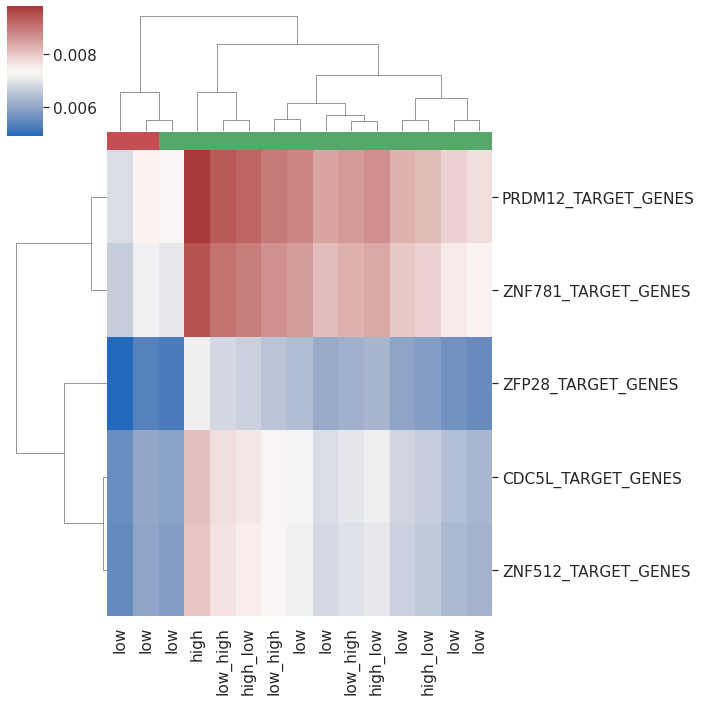

In [19]:
sns.set(font_scale=1.4)
g = sns.clustermap(cell.rename(icombo_region_dict).T, cmap='vlag', yticklabels=True, col_colors=color_df['synergy_label'].values)
g.savefig('SAFER-C3.jpeg', dpi=300)

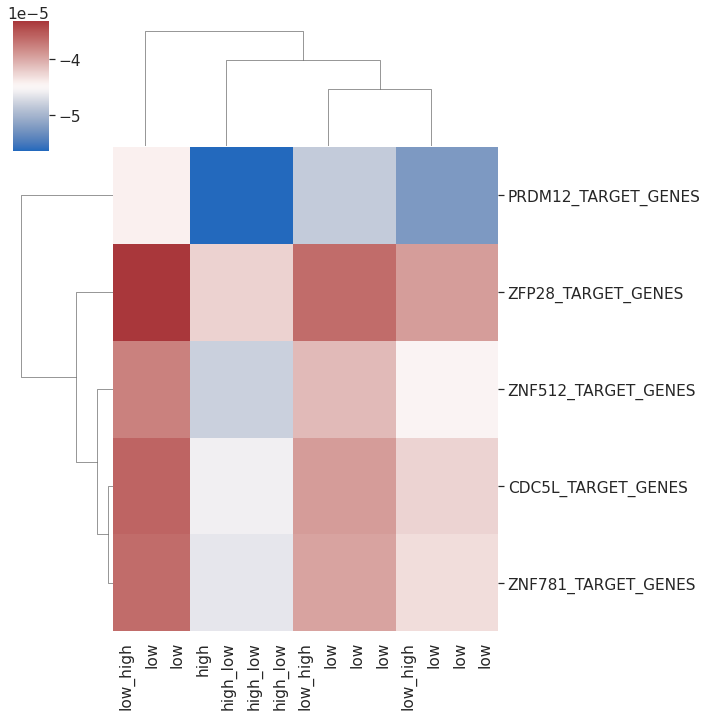

In [20]:
sns.set(font_scale=1.4)
sns.clustermap(target.rename(icombo_region_dict).T, cmap='vlag', yticklabels=True)

<AxesSubplot:ylabel='Geneset'>

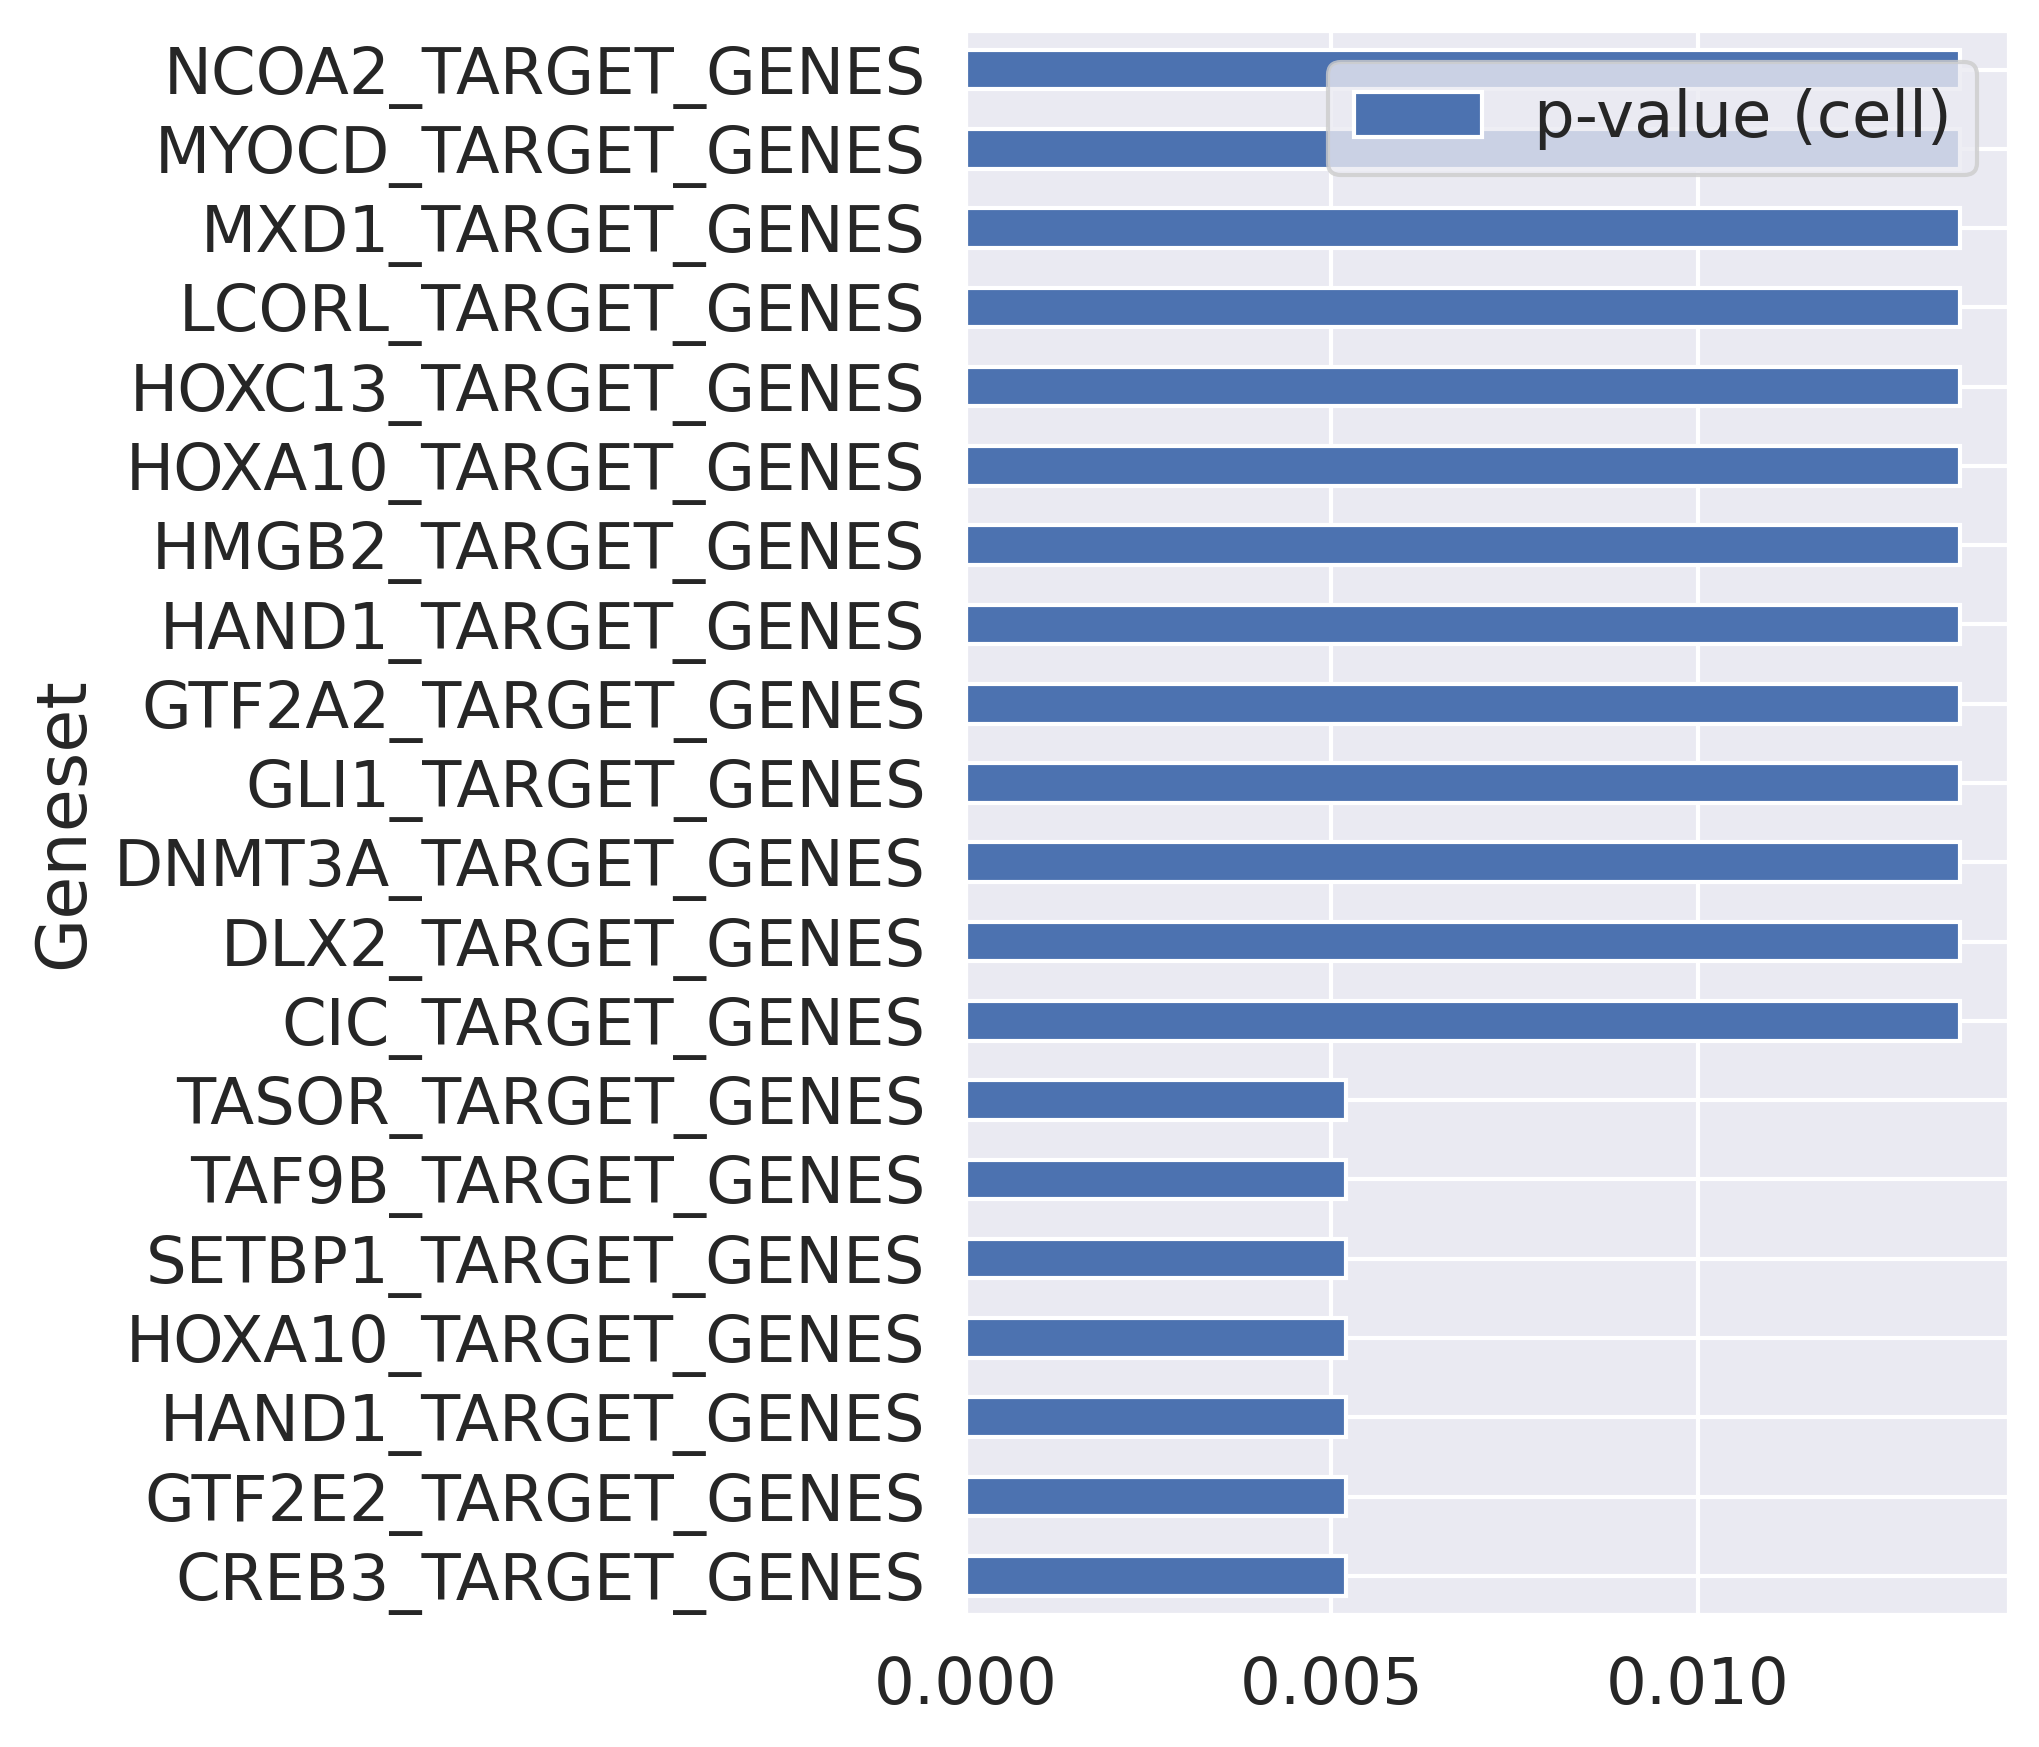

In [21]:
fig, ax = plt.subplots(1, figsize=(4,7), dpi=300)
per_triplet_ttest_df[['Geneset', 'p-value (cell)']].head(20).set_index('Geneset').plot(kind='barh', ax=ax)

In [22]:
cell.rename(icombo_region_dict).T

,low,low,low_high,low,low,low,low_high,low,low,low,low_high,high_low,high_low,high_low,high
CDC5L_TARGET_GENES,0.005558,0.006037,0.007005,0.005919,0.006399,0.006881,0.007367,0.006273,0.006753,0.007235,0.007721,0.006634,0.007113,0.007596,0.008082
PRDM12_TARGET_GENES,0.006872,0.007425,0.008541,0.007289,0.007842,0.008398,0.008958,0.007697,0.008250,0.008806,0.009366,0.008113,0.008666,0.009222,0.009782
ZFP28_TARGET_GENES,0.004899,0.005321,0.006172,0.005217,0.005639,0.006063,0.006490,0.005528,0.005950,0.006374,0.006801,0.005845,0.006267,0.006691,0.007118
ZNF512_TARGET_GENES,0.005491,0.005968,0.006931,0.005851,0.006328,0.006808,0.007291,0.006203,0.006680,0.007159,0.007643,0.006562,0.007039,0.007518,0.008001
ZNF781_TARGET_GENES,0.006616,0.007155,0.008241,0.007022,0.007561,0.008102,0.008647,0.007419,0.007958,0.008499,0.009044,0.007824,0.008363,0.008904,0.009449
